# Problem statement
Taking into consideration all the independent features and predict the amount spent.

In [149]:
#Data manipulation libraries
import pandas as pd
import numpy as np

#Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

#for bell curve
import scipy.stats as sci

#Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

#Importing train test split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve

#Importing rfe
from sklearn.feature_selection import RFE

#Importing VIF for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Importing regressor models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import xgboost

#importing metrics for evaluation
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
#Reading data and checking 1st 5 cols
insurance_df = pd.read_csv('Medibuddy Insurance Data Price (1) (2).csv')
personal_details_df = pd.read_excel('Medibuddy insurance data personal details (1) (2).xlsx')

In [3]:
df = insurance_df.merge(personal_details_df, how='left', on='Policy no.')
df.head()

,Policy no.,age,sex,bmi,charges in INR,children,smoker,region
0,PLC156898,19,female,27.900,16884.92400,0,yes,southwest
1,PLC156907,18,male,33.770,1725.55230,1,no,southeast
2,PLC156916,28,male,33.000,4449.46200,3,no,southeast
3,PLC156925,33,male,22.705,21984.47061,0,no,northwest
4,PLC156934,32,male,28.880,3866.85520,0,no,northwest


In [4]:
#Checking last 5 cols
df.tail()

,Policy no.,age,sex,bmi,charges in INR,children,smoker,region
1333,PLC168895,50,male,30.97,10600.5483,3,no,northwest
1334,PLC168904,18,female,31.92,2205.9808,0,no,northeast
1335,PLC168913,18,female,36.85,1629.8335,0,no,southeast
1336,PLC168922,21,female,25.80,2007.9450,0,no,southwest
1337,PLC168931,61,female,29.07,29141.3603,0,yes,northwest


In [5]:
df.shape

(1338, 8)

In [6]:
df.corr()

,age,bmi,charges in INR,children
age,1.000000,0.109272,0.299008,0.042469
bmi,0.109272,1.000000,0.198341,0.012759
charges in INR,0.299008,0.198341,1.000000,0.067998
children,0.042469,0.012759,0.067998,1.000000


In [7]:
#Checking any missing value.
df.isnull().sum()

Policy no.        0
age               0
sex               0
bmi               0
charges in INR    0
children          0
smoker            0
region            0
dtype: int64

### Dropping Policy no. because it is not necessary for prediction.

In [8]:
df = df.drop('Policy no.', axis=1)

In [9]:
df.head()

,age,sex,bmi,charges in INR,children,smoker,region
0,19,female,27.900,16884.92400,0,yes,southwest
1,18,male,33.770,1725.55230,1,no,southeast
2,28,male,33.000,4449.46200,3,no,southeast
3,33,male,22.705,21984.47061,0,no,northwest
4,32,male,28.880,3866.85520,0,no,northwest


In [10]:
#checking unique values of categorical columns.
for i in df.columns:
    if df[i].dtype == 'object':
        print (df[i].unique())

['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


## Converting categorical into numeric using label encoder

In [11]:
le = LabelEncoder()

In [12]:
#Udf for label encoding categorical into continous.
def label_enc():
    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = le.fit_transform(df[col])

In [13]:
label_enc()

In [14]:
df.head()

,age,sex,bmi,charges in INR,children,smoker,region
0,19,0,27.900,16884.92400,0,1,3
1,18,1,33.770,1725.55230,1,0,2
2,28,1,33.000,4449.46200,3,0,2
3,33,1,22.705,21984.47061,0,0,1
4,32,1,28.880,3866.85520,0,0,1


# Building a custom summary function for EDA

In [15]:
def describe(my_df):
    cols = []
    for i in my_df.columns:
        if my_df[i].dtype != 'object':
            cols.append(i)
            
    result = pd.DataFrame(columns = cols, index=['Datatype', 'Count', 'min', 'Q1', 'Q2', 'mean', 'Q3', 'max', 'Std',
                                                 'Skewness', 'Kurtosis', 'Range', 'IQR', 'Skewness comment', 'Outlier comment',
                                                'Kurtosis comment'])
    
    #Building custom summary
    for i in result.columns:
        result.loc['Datatype', i] = my_df[i].dtype
        result.loc['Count', i] = my_df[i].count()
        result.loc['min',i] = my_df[i].min()
        result.loc['Q1',i] = my_df[i].quantile(0.25)
        result.loc['Q2',i] =my_df[i].quantile(0.5)
        result.loc['mean',i] =round(my_df[i].mean(),2)
        result.loc['Q3',i] =my_df[i].quantile(0.75)
        result.loc['max',i] =my_df[i].max()
        result.loc['Std',i] =round(my_df[i].std(),2)
        result.loc['Skewness',i] =round(my_df[i].skew(),2)
        result.loc['Kurtosis',i] =round(my_df[i].kurt(),2)
        result.loc['Range',i] = my_df[i].max() - my_df[i].min()
        result.loc['IQR',i] = my_df[i].quantile(0.75) - my_df[i].quantile(0.25)
        
        
        #Adding comments for skewness
        if result.loc['Skewness', i] <= -1:
            sk_label = 'Highly negatively skewed'
        elif -1  < result.loc['Skewness', i] <= -0.5:
            sk_label = 'Moderatively negatively Skewed'
        elif -0.5  < result.loc['Skewness', i] < 0:
            sk_label = 'Approximately Normal distribution(-ve)'
        elif 0  <= result.loc['Skewness', i] < 0.5:
            sk_label = 'Approximately Normal distribution(+ve)'
        elif 0.5  <= result.loc['Skewness', i] < 1:
            sk_label = 'Moderatively positively Skewed'
        elif result.loc['Skewness', i] >= 1:
            sk_label = 'Highly positively Skewed'
        else:
            sk_label = 'Error'
            
        result.loc['Skewness comment', i] = sk_label
            
            
            
         #Adding comments for Kurtosis
        if result.loc['Kurtosis', i] <= -1:
            kt_label = 'Highly platykurtic curve'
        elif -1  < result.loc['Kurtosis', i] <= -0.5:
            kt_label = 'Moderatively platykurtic curve'
        elif -0.5  < result.loc['Kurtosis', i] < 0.5:
            kt_label = 'Mesokurtic curve'
        elif 0.5  <= result.loc['Kurtosis', i] < 1:
            kt_label = 'Moderatively laptokurtic curve'
        elif result.loc['Kurtosis', i] >= 1:
            kt_label = 'Highly laptokurtic curve'
        else:
            kt_label = 'Error'
            
        result.loc['Kurtosis comment', i] = kt_label
        
        
        #Adding comments for Outliers
        upper_limit = result.loc['Q3',i] + (1.5 * result.loc['IQR', i])
        lower_limit = result.loc['Q1', i]- (1.5 * result.loc['IQR', i])
        if len([x for x in my_df[i] if x < lower_limit or x > upper_limit]) > 0:
            outlier_label = 'Has outliers'
        else:
            outlier_label = 'No outliers'
            
        result.loc['Outlier comment', i] = outlier_label
    display(result)

In [16]:
describe(df)

,age,sex,bmi,charges in INR,children,smoker,region
Datatype,int64,int32,float64,float64,int64,int32,int32
Count,1338,1338,1338,1338,1338,1338,1338
min,18,0,15.96,1121.8739,0,0,0
Q1,27.0,0.0,26.29625,4740.28715,0.0,0.0,1.0
Q2,39.0,1.0,30.4,9382.033,1.0,0.0,2.0
mean,39.21,0.51,30.66,13270.42,1.09,0.2,1.52
Q3,51.0,1.0,34.69375,16639.912515,2.0,0.0,2.0
max,64,1,53.13,63770.42801,5,1,3
Std,14.05,0.5,6.1,12110.01,1.21,0.4,1.1
Skewness,0.06,-0.02,0.28,1.52,0.94,1.46,-0.04


## Analysis from custom summary
1. All features are integer except bmi and charges in INR which are float.
2. Features smoker, bmi and charges in INR having outliers.
3. smoker and charges in INR are highly positively skewed.


## Performing outlier treatment

In [17]:
def replace_outlier(a, col, method = 'Quartile', strategy = 'Median'):
    a = df.drop('smoker', axis=1) #not taking smoker column bcz its highly imbalanced
    col_data = a[col]
    
    
    #using quartile to set the values
    if method == 'Quartile':
        Q2 = col_data.quantile(0.5)
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
    #using stdev to set the values
    elif method == 'stdev':
        mean = col_data.mean()
        stdev = col_data.std()
    
        lower_limit = mean - 2* stdev
        upper_limit = mean + 2* stdev
    
    else:
        print('pass a correct method')
        
    #Checking outliers and density
    outliers = a.loc[(col_data < lower_limit) | (col_data > upper_limit), col]
    outlier_density = round(len(outliers)/ len(a), 2)

    if len(outliers) == 0:
        print(f'Feature {col} does not have any outliers')
        print('\n')
        
    else: 
        print(f'Feature {col} has outliers')
        print('\n')
        print(f'Total no of outliers in {col} are {len(outliers)}')
        print('\n')
        print(f'Outlier percentage in {col} is {outlier_density}')
        print('\n')
        
        display(a[(col_data < lower_limit) | (col_data > upper_limit)]) #It will display outliers 


    #Replacing outliers
    if strategy == 'Median':
        a.loc[(col_data < lower_limit),col] = lower_limit
        a.loc[ (col_data > upper_limit),col] = upper_limit
    elif strategy == 'Mean':
        a.loc[(col_data < lower_limit),col] = lower_limit
        a.loc[ (col_data > upper_limit),col] = upper_limit
        
    return(a)
        
        


## ODT plots
1. Descriptive plot.
2. Histogram with outliers.
3. Histogram without outliers.

In [18]:
def odt_plots(df, col):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (25, 8))
    # descriptive statistics boxplots 
    sns.boxplot(df[col], ax= ax1)
    ax1.set_title(col + ' boxplot')
    ax1.set_xlabel('Boxplot')
    ax1.set_ylabel('values')
    
    #plotting histogram with outliers
    sns.distplot(df[col], ax= ax2, fit = sci.norm) #sci.norm will give bell curve 
    ax2.axvline(df[col].mean(), color= 'g')
    ax2.axvline(df[col].median(), color= 'b')
    ax2.set_title(col + ' Histogram with outliers')
    ax2.set_xlabel('Boxplot')
    ax2.set_ylabel('values')
    
    #Replacing outliers
    df_out = replace_outlier(df, col)
    
     #plotting histogram without outliers
    sns.distplot(df[col], ax= ax3, fit= sci.norm)
    ax3.axvline(df[col].mean(), color= 'g')
    ax3.axvline(df[col].median(), color= 'b')
    ax3.set_title(col + ' Histogram without outliers')
    ax3.set_xlabel('Density')
    ax3.set_ylabel('values')
    plt.show()
    
    

Feature age does not have any outliers




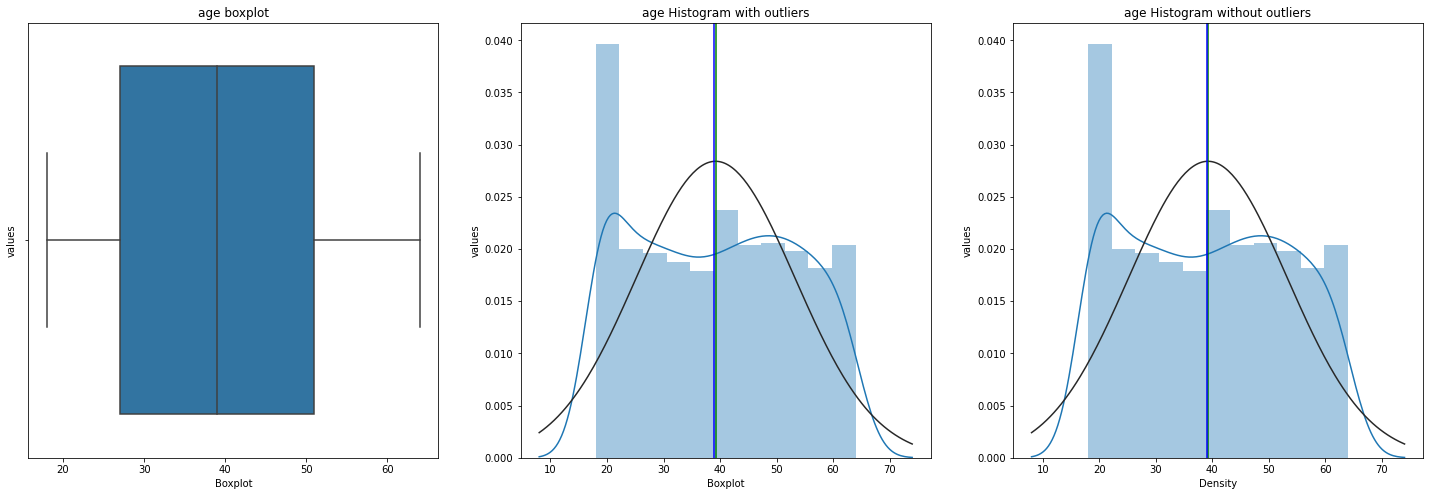

Feature sex does not have any outliers




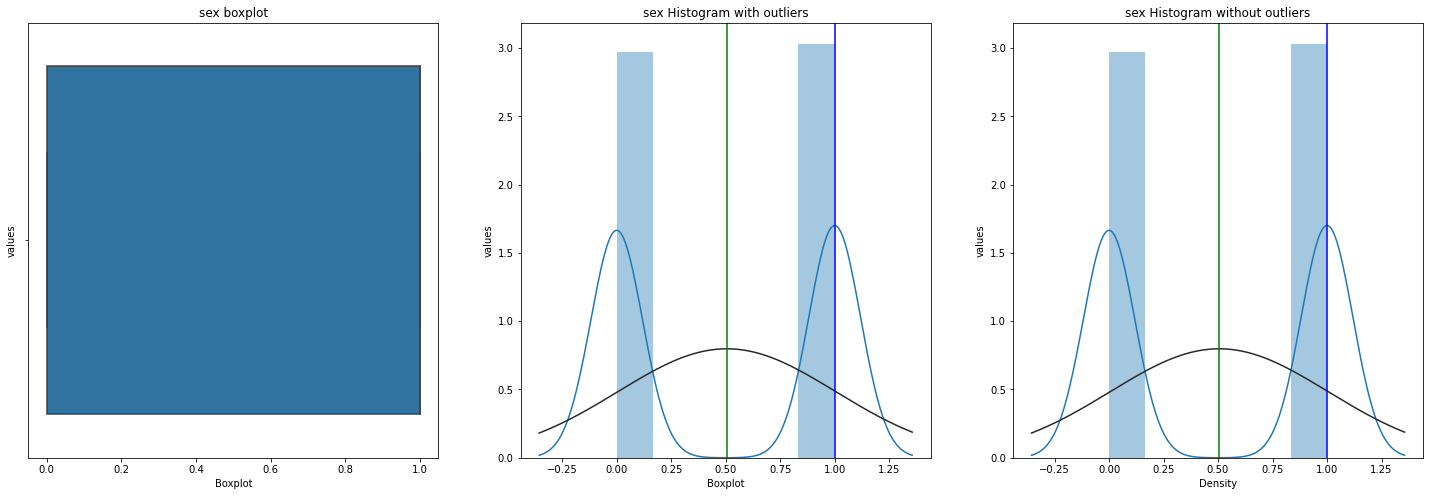

Feature bmi has outliers


Total no of outliers in bmi are 9


Outlier percentage in bmi is 0.01




,age,sex,bmi,charges in INR,children,region
116,58,1,49.06,11381.32540,0,2
286,46,0,48.07,9432.92530,2,0
401,47,1,47.52,8083.91980,1,2
543,54,0,47.41,63770.42801,0,2
847,23,1,50.38,2438.05520,1,2
860,37,0,47.60,46113.51100,2,3
1047,22,1,52.58,44501.39820,1,2
1088,52,1,47.74,9748.91060,1,2
1317,18,1,53.13,1163.46270,0,2


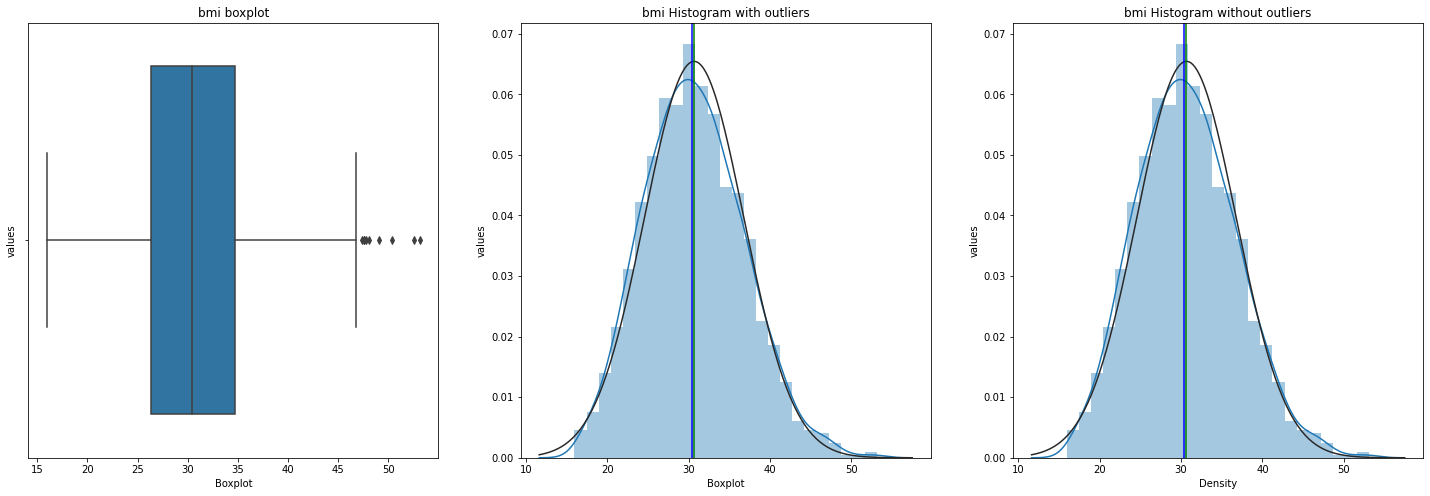

Feature charges in INR has outliers


Total no of outliers in charges in INR are 139


Outlier percentage in charges in INR is 0.1




,age,sex,bmi,charges in INR,children,region
14,27,1,42.130,39611.75770,0,2
19,30,1,35.300,36837.46700,0,3
23,34,0,31.920,37701.87680,1,0
29,31,1,36.300,38711.00000,2,3
30,22,1,35.600,35585.57600,0,3
...,...,...,...,...,...,...
1300,45,1,30.360,62592.87309,0,2
1301,62,1,30.875,46718.16325,3,1
1303,43,1,27.800,37829.72420,0,3
1313,19,0,34.700,36397.57600,2,3


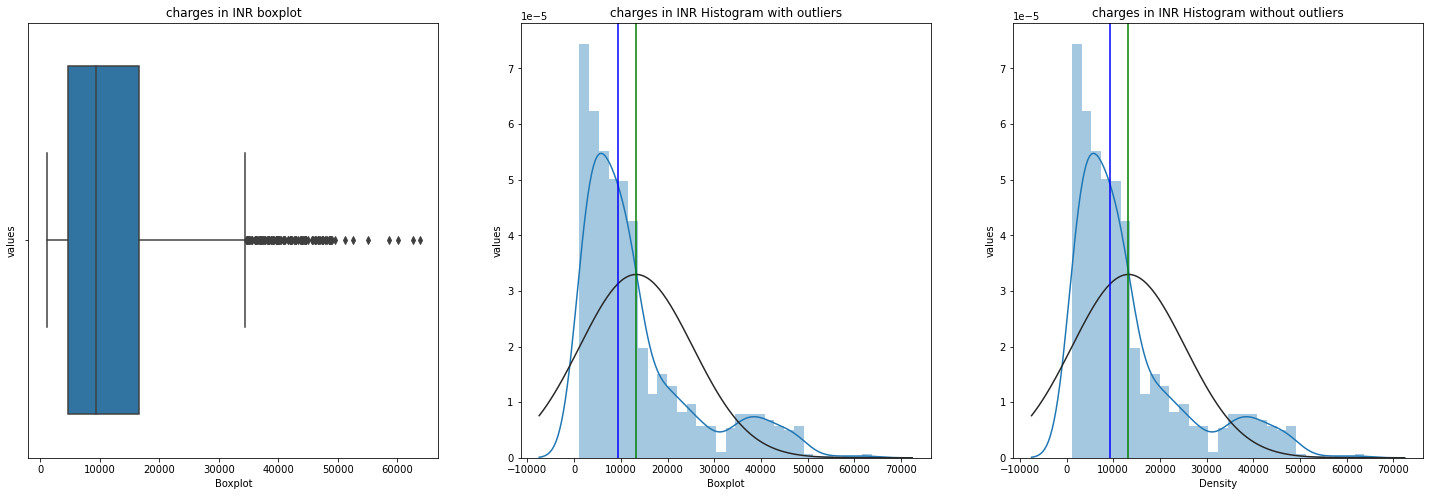

Feature children does not have any outliers




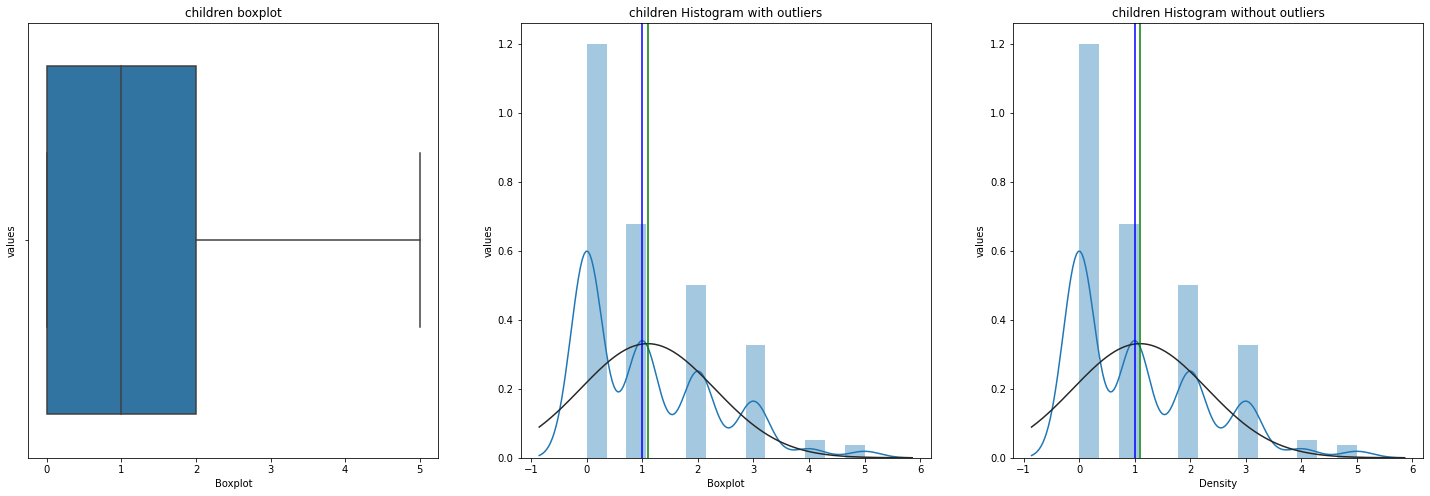

Feature region does not have any outliers




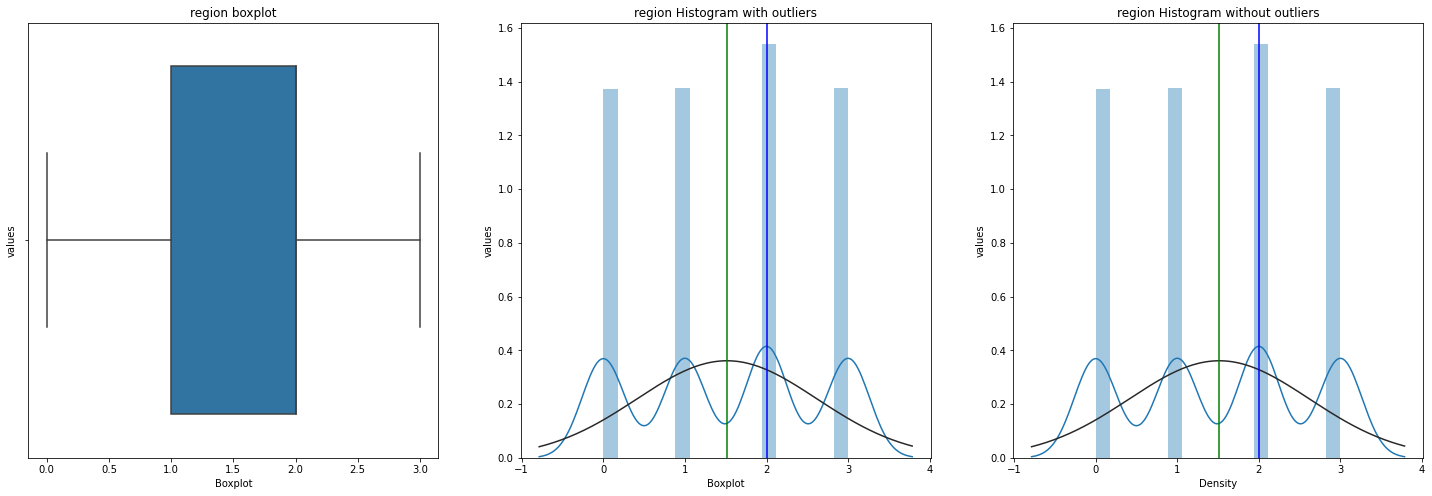

In [19]:
for col in (df.drop('smoker', axis=1)).columns:
    odt_plots(df, col)

## Multivariate analysis using regression

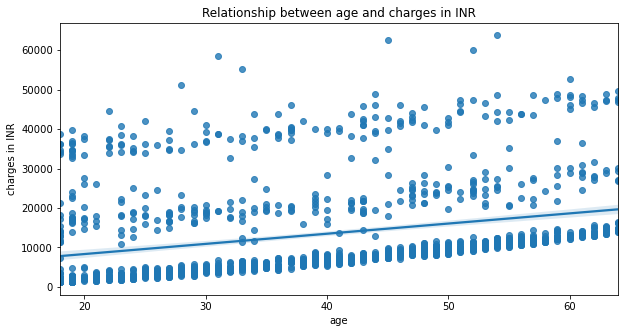

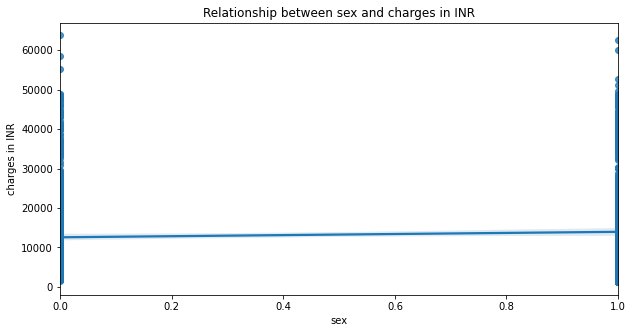

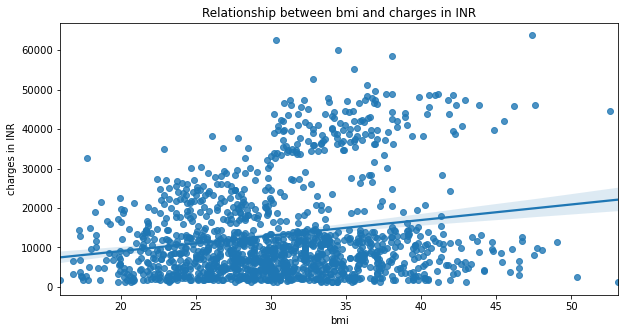

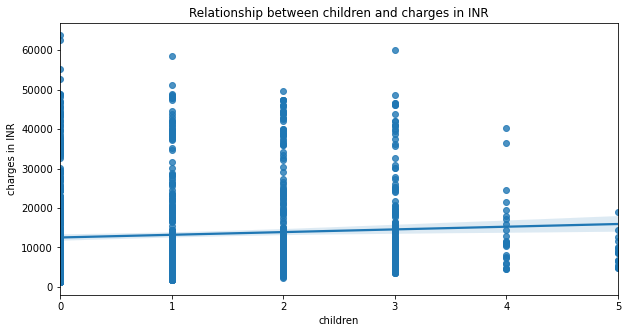

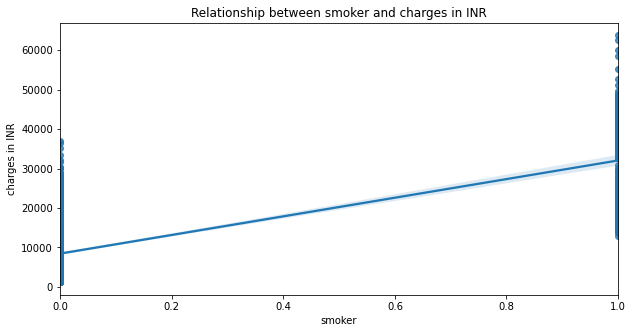

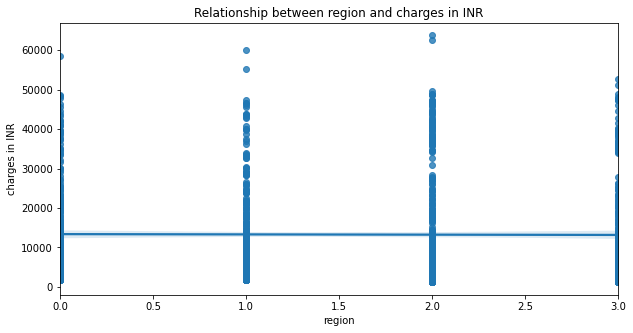

In [20]:
for col in df.columns:
    if col != 'charges in INR':
        fig, ax1 = plt.subplots(figsize= (10, 5))
        sns.regplot(x= df[col], y=df['charges in INR'], ax=ax1).set_title(f'Relationship between {col} and charges in INR')

## Analysis
1. Age and bmi are slightly positive correlated with target (charges in INR).
2. sex, children, smoker and region have no correlation with target (charges in INR).

## Multicollinearity check

1. using correlation heatmap

In [21]:
corr = df.corr()

<AxesSubplot:>

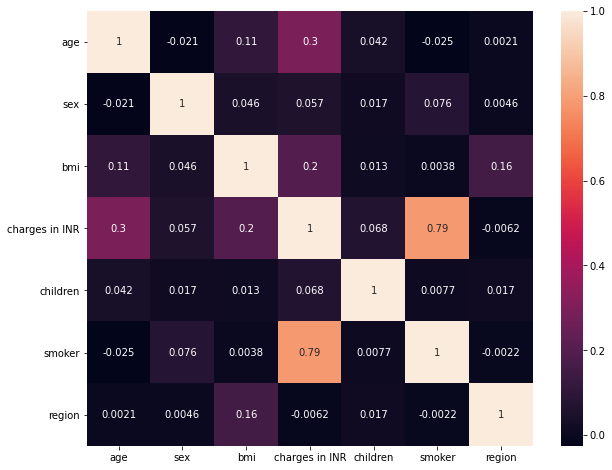

In [22]:
f, ax = plt.subplots(figsize= (10,8))
sns.heatmap(corr, annot=True)

2. Using VIF

In [23]:
def VIF(features):
    VIF = pd.DataFrame()
    VIF['vif_factor'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    VIF['features'] = features.columns
    return VIF.sort_values('vif_factor', ascending= False)

In [24]:
VIF(df.drop('charges in INR', axis=1))

,vif_factor,features
2,10.371829,bmi
0,7.551348,age
5,2.924528,region
1,2.001061,sex
3,1.801245,children
4,1.256837,smoker


## Analysis 

Age and bmi have multicollinearity. Therefore multicollinearity exist.

## Checking correlation with target feature.

In [25]:
def correlation_with_target(data, tcol):
    independent_variables = data.drop(tcol, axis=1).columns
    corr_result = []
    for col in independent_variables:
        corr_result.append(data[tcol].corr(data[col]))
    result = pd.DataFrame([independent_variables, corr_result], index=['independent_variables', 'correlation']).T
    return result.sort_values('correlation', ascending= False)

In [26]:
correlation_with_target(df, 'charges in INR')

,independent_variables,correlation
4,smoker,0.787251
0,age,0.299008
2,bmi,0.198341
3,children,0.067998
1,sex,0.057292
5,region,-0.006208


## Analysis
- smoker, region and children are least correlated with target(charges in INR).
- age and bmi are only features that having good correlation with target(charges in INR).

In [27]:
def PCA1(x):
    n_comp = len(x.columns)   #no. of columns in df
    
    #Applying standard scaler
    x = StandardScaler().fit_transform(x) 
    
    
    #Applying PCA
    for i in range(1, n_comp):         
        pca = PCA(n_components = i)      
        p_comp = pca.fit_transform(x)
        evr = np.cumsum(pca.explained_variance_ratio_)  
        if evr[i-1] > 0.8:             
            n_components = i
            break
    print('explained_variance_ratio after PCA is :', evr)
    
    #Creating a dataframe
    col = []
    for j in range(1, n_components + 1):
        col.append('pc_'+ str(j))
    pca_df = pd.DataFrame(p_comp, columns=col)
    return pca_df

In [28]:
transform_df = PCA1(df.drop('charges in INR', axis=1))

explained_variance_ratio after PCA is : [0.20060309 0.38196949 0.55189263 0.71276965 0.8667639 ]


In [29]:
transform_df.head()

,pc_1,pc_2,pc_3,pc_4,pc_5
0,0.413805,1.119147,-1.784825,0.684093,2.149239
1,-0.122760,0.822142,-1.004169,0.832861,-1.139038
2,-0.624424,0.637478,0.557885,1.541617,-1.059054
3,1.363097,0.427586,-0.428150,-0.418729,-1.094912
4,0.692600,0.451383,-0.604048,-0.532564,-1.138595


## Joining pca features with target feature

In [30]:
transform_df = transform_df.join(df['charges in INR'], how= 'left')

In [31]:
transform_df.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,charges in INR
0,0.413805,1.119147,-1.784825,0.684093,2.149239,16884.92400
1,-0.122760,0.822142,-1.004169,0.832861,-1.139038,1725.55230
2,-0.624424,0.637478,0.557885,1.541617,-1.059054,4449.46200
3,1.363097,0.427586,-0.428150,-0.418729,-1.094912,21984.47061
4,0.692600,0.451383,-0.604048,-0.532564,-1.138595,3866.85520


## Model Building
1. Train-test split
2. Cross-validation
3. Hyperparameter tuning

#### Train test split function

In [32]:
def train_and_test_split(data, tcol, Test_size=0.3, Random_state = 42):
    x = data.drop(tcol, axis= 1)
    y = data[tcol]
    return train_test_split(x, y, test_size= Test_size, random_state=Random_state)

#### Model building function

In [33]:
def build_model(model_name, estimator, data, tcol):
    xtrain, xtest, ytrain, ytest = train_and_test_split(data, tcol)
    estimator.fit(xtrain, ytrain)
    ypred = estimator.predict(xtest)
    rmse = np.sqrt(mean_squared_error(ytest, ypred))
    accuracy = r2_score(ytest, ypred)
    return [model_name, rmse, accuracy]

In [34]:
build_model(model_name= 'Linear Reg', estimator= LinearRegression(), data=transform_df, tcol='charges in INR')

['Linear Reg', 5818.091993458922, 0.7691365440661229]

## Building multiple models function

In [115]:
def multiple_models(data, tcol):
    colnames = ['model_name', 'rmse', 'r2_score']
    result = pd.DataFrame(columns= colnames)
    result.loc[len(result)] = build_model('Linear regression', LinearRegression(), data, tcol)
    result.loc[len(result)] = build_model('Lasso regression', Lasso(), data, tcol)
    result.loc[len(result)] = build_model('Ridge regression', Ridge(), data, tcol)
    result.loc[len(result)] = build_model('SVR', SVR(), data, tcol)
    result.loc[len(result)] = build_model('KNeighborsRegressor', KNeighborsRegressor(), data, tcol)
    result.loc[len(result)] = build_model('RandomForestRegressor', RandomForestRegressor(), data, tcol)
    result.loc[len(result)] = build_model('XGBRegressor', XGBRegressor(), data, tcol)
    result.loc[len(result)] = build_model('DecisionTreeRegressor', DecisionTreeRegressor(), data, tcol)
    result.loc[len(result)] = build_model('AdaBoostRegressor', AdaBoostRegressor(), data, tcol)
    result.loc[len(result)] = build_model('GradientBoostingRegressor', GradientBoostingRegressor(), data, tcol)
    
    return result.sort_values('r2_score', ascending= False)

In [36]:
multiple_models(data= transform_df, tcol='charges in INR')

,model_name,rmse,r2_score
9,GradientBoostingRegressor,5291.740748,0.809019
5,RandomForestRegressor,5407.429686,0.800577
6,XGBRegressor,5539.906336,0.790686
4,KNeighborsRegressor,5650.918189,0.782213
1,Lasso regression,5818.081044,0.769137
0,Linear regression,5818.091993,0.769137
2,Ridge regression,5818.320610,0.769118
7,DecisionTreeRegressor,7435.979893,0.622888
8,AdaBoostRegressor,8186.413231,0.542931
3,SVR,12572.491361,-0.078045


Using train_test_split toop models are GradientBoost, RandomForest and XGBReg

## Cross validation

In [116]:
def K_fold_CV(x, y, fold=10):
    score_lr = cross_val_score(LinearRegression(), x, y, cv= fold)
    score_la = cross_val_score(Lasso(), x, y, cv= fold)
    score_ri = cross_val_score(Ridge(), x, y, cv= fold)
    score_svr = cross_val_score(SVR(), x, y, cv= fold)
    score_dt = cross_val_score(DecisionTreeRegressor(), x, y, cv= fold)
    score_knn = cross_val_score(KNeighborsRegressor(), x, y, cv= fold)
    score_rm = cross_val_score(RandomForestRegressor(), x, y, cv= fold)
    score_ad = cross_val_score(AdaBoostRegressor(), x, y, cv= fold)
    score_gr = cross_val_score(GradientBoostingRegressor(), x, y, cv= fold)
    score_xgb = cross_val_score(XGBRegressor(), x, y, cv= fold)
    
    model_names = ['LinearRegression', 'Lasso', 'Ridge', 'SVR', 'DecisionTreeRegressor', 'KNeighborsRegressor', 
                   'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
    
    scores = [score_lr, score_la, score_ri, score_svr, score_dt, score_knn, score_rm, score_ad, score_gr, score_xgb]
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_names = model_names[i]
        temp = [m_names, score_mean, score_std]
        result.append(temp)
    
    K_fold_df = pd.DataFrame(result, columns= ['model_names', 'score_mean', 'score_std'])
    return K_fold_df.sort_values('score_mean', ascending= False)

In [117]:
K_fold_CV(x = transform_df.drop('charges in INR', axis=1), y= transform_df['charges in INR'])

,model_names,score_mean,score_std
8,GradientBoostingRegressor,0.810524,0.047406
6,RandomForestRegressor,0.799312,0.046327
9,XGBRegressor,0.788577,0.064751
5,KNeighborsRegressor,0.774899,0.032659
2,Ridge,0.744965,0.042072
1,Lasso,0.744959,0.042128
0,LinearRegression,0.744957,0.042148
4,DecisionTreeRegressor,0.639319,0.078508
7,AdaBoostRegressor,0.549426,0.042678
3,SVR,-0.098930,0.030021


Using cross validation GBoost performing well and its accuracy also increased as cmpared to train_test_split.

Now, trying to increase more performance of models by hyperparameter optimization.

## Hyperparameter tuning

In [118]:
def tuning(x,y, fold= 10):
    #parameter grid for all the models
    param_dt = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_features': ['auto','sqrt','log2',2,3,4,5,6,7,8]}
    param_knn = {'n_neighbors': [5, 10, 20, 40, 60, 80, 100]}
    param_rf = {'n_estimators': [100, 200, 300], 'max_depth': [3,5,7,10]}
    param_ad = {'n_estimators': [100, 200, 300], 'loss': ['linear', 'square', 'exponential']} #, 'base_estimator': ['LinearRegression', 'DecisionTreeRegressor']
    param_gr = {'n_estimators': [200, 300], 'learning_rate':[0.1, 0.01]}
    param_xgb = {'eta': [0.01, 0.1, 0.3], 'max_depth':[3,5,7,10], 'subsample': [0.5, 0.7, 1]}
    param_rd = {'alpha': [1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 0, 1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    param_ls = {'alpha': [1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 0, 1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    #param_svr = {}
                
    
    
# hyperparameter tuning (passing hyperparameters in gridsearch)

    tuned_las = GridSearchCV(Lasso(), param_ls, cv= fold)
    tuned_rd = GridSearchCV(Ridge(), param_rd, cv= fold)
    tuned_knn = GridSearchCV(KNeighborsRegressor(), param_knn, cv= fold)
    tuned_dt = GridSearchCV(DecisionTreeRegressor(), param_dt, cv= fold)
    tuned_rf = GridSearchCV(RandomForestRegressor(), param_rf, cv= fold)
    tuned_ad = GridSearchCV(AdaBoostRegressor(), param_ad, cv= fold)
    tuned_gr = GridSearchCV(GradientBoostingRegressor(), param_gr, cv= fold)
    tuned_xgb = GridSearchCV(XGBRegressor(), param_xgb, cv= fold)
    
    
#Fitting x and y
    tuned_las.fit(x, y)
    tuned_rd.fit(x, y)
    tuned_knn.fit(x, y)
    tuned_dt.fit(x, y)
    tuned_rf.fit(x, y)
    tuned_ad.fit(x, y)
    tuned_gr.fit(x, y)
    tuned_xgb.fit(x, y)
    
    
    tune = [tuned_las, tuned_rd, tuned_knn, tuned_dt, tuned_rf, tuned_ad, tuned_gr, tuned_xgb]
    models = ['Lasso', 'Ridge', 'Knn', 'Decision_Tree', 'Random_forest', 'Adaboost', 'Gboost', 'XGBoost']
    for i in range(len(tune)):
        print('model_name:', models[i])
        print('best_params:', tune[i].best_params_)

In [44]:
tuning(x = transform_df.drop('charges in INR', axis=1), y= transform_df['charges in INR'])

model_name: Lasso
best_params: {'alpha': 30}
model_name: Ridge
best_params: {'alpha': 8}
model_name: Knn
best_params: {'n_neighbors': 10}
model_name: Decision_Tree
best_params: {'criterion': 'friedman_mse', 'max_features': 5}
model_name: Random_forest
best_params: {'max_depth': 10, 'n_estimators': 300}
model_name: Adaboost
best_params: {'loss': 'linear', 'n_estimators': 100}
model_name: Gboost
best_params: {'learning_rate': 0.1, 'n_estimators': 200}
model_name: XGBoost
best_params: {'eta': 0.1, 'max_depth': 3, 'subsample': 0.5}


Now, applying best parameters to get best models performance.

## Post hyperparameter tuning

In [121]:
def cv_post_hpt(x, y, fold=10):
    score_lr = cross_val_score(LinearRegression(), x, y, cv= fold)
    score_la = cross_val_score(Lasso(alpha = 30), x, y, cv= fold)
    score_ri = cross_val_score(Ridge(alpha = 8), x, y, cv= fold)
    score_svr = cross_val_score(SVR(), x, y, cv= fold)
    score_dt = cross_val_score(DecisionTreeRegressor(criterion = 'friedman_mse' , max_features = 5), x, y, cv= fold)
    score_knn = cross_val_score(KNeighborsRegressor(n_neighbors = 10), x, y, cv= fold)
    score_rm = cross_val_score(RandomForestRegressor(max_depth = 10, n_estimators = 300), x, y, cv= fold)
    score_ad = cross_val_score(AdaBoostRegressor(loss= 'linear', n_estimators = 100), x, y, cv= fold)
    score_gr = cross_val_score(GradientBoostingRegressor(learning_rate = 0.1, n_estimators= 200), x, y, cv= fold)
    score_xgb = cross_val_score(XGBRegressor(eta = 0.1, max_depth = 3, subsample = 0.5), x, y, cv= fold)
    
    model_names = ['LinearRegression', 'Lasso', 'Ridge', 'SVR', 'DecisionTreeRegressor', 'KNeighborsRegressor', 
                   'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
    
    scores = [score_lr, score_la, score_ri, score_svr, score_dt, score_knn, score_rm, score_ad, score_gr, score_xgb]
    result = []
    for i in range(len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_names = model_names[i]
        temp = [m_names, score_mean, score_std]
        result.append(temp)
    
    K_fold_df = pd.DataFrame(result, columns= ['model_names', 'score_mean', 'score_std'])
    return K_fold_df.sort_values('score_mean', ascending= False)

In [120]:
cv_post_hpt(x = transform_df.drop('charges in INR', axis=1), y= transform_df['charges in INR'])

,model_names,score_mean,score_std
9,XGBRegressor,0.813322,0.046879
8,GradientBoostingRegressor,0.807286,0.048660
6,RandomForestRegressor,0.805425,0.044058
5,KNeighborsRegressor,0.785987,0.031789
2,Ridge,0.744991,0.041546
1,Lasso,0.744989,0.041574
0,LinearRegression,0.744957,0.042148
4,DecisionTreeRegressor,0.642707,0.079965
7,AdaBoostRegressor,0.520241,0.061080
3,SVR,-0.098930,0.030021


After post HPT, XGB performance came out to be best and then GradientBoost.

## Clustering

In [52]:
from sklearn.cluster import KMeans

In [53]:
labels = KMeans(n_clusters=2, random_state=50)

In [54]:
clusters = labels.fit_predict(df.drop('charges in INR', axis=1))

<AxesSubplot:xlabel='age', ylabel='charges in INR'>

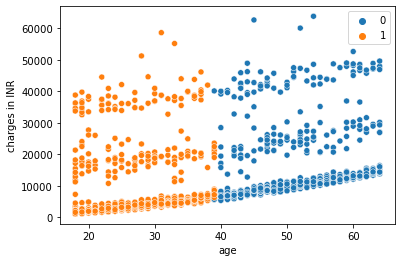

In [57]:
sns.scatterplot(x= df['age'], y= df['charges in INR'], hue=clusters)  #comparing one feature with target

## udf for comparing features and target using clustering scatterplot

In [91]:
def clustering(x, tcol, cluster):
    column = list(set(list(x.columns))- set(df['charges in INR']))
    r = int(len(column) / 2)
    if r %2 == 0:
        r = r
    else:
        r += 1 #r=r+1

        
    f, ax = plt.subplots(r,2, figsize= (15,15))
    a = 0
    for row in range(r):
        for col in range(0,2):
            if a != len(column):
                ax[row][col].scatter(x[tcol], x[column[a]], c= cluster)
                ax[row][col].set_xlabel(tcol)
                ax[row][col].set_ylabel(column[a])
                a += 1

In [92]:
x = df.drop('charges in INR', axis=1)

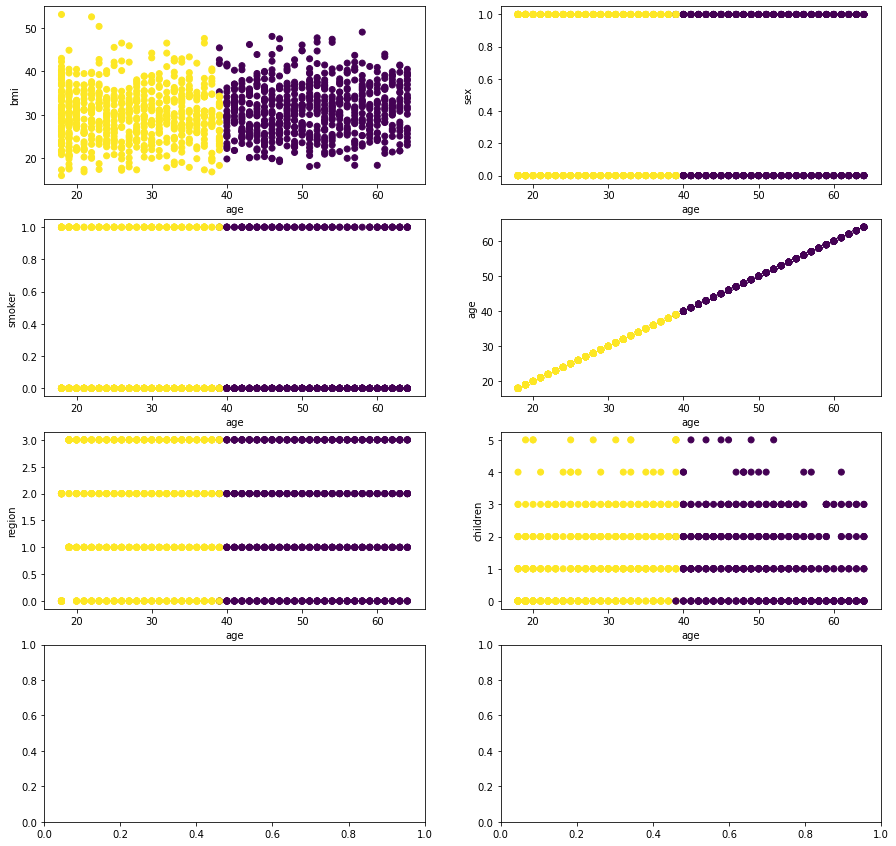

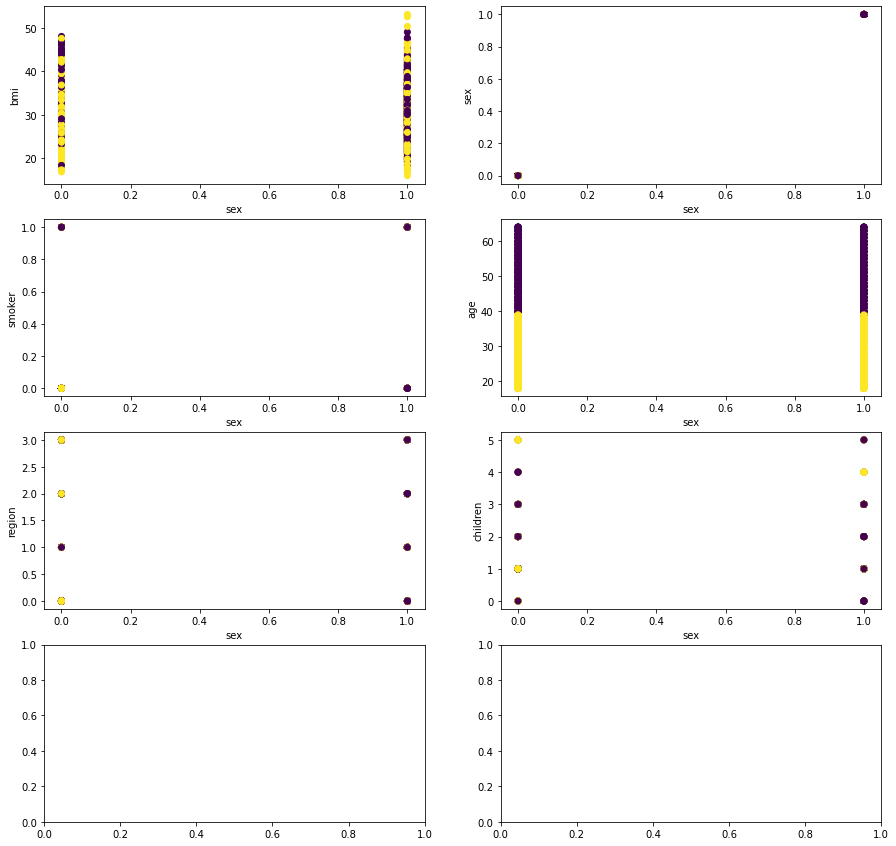

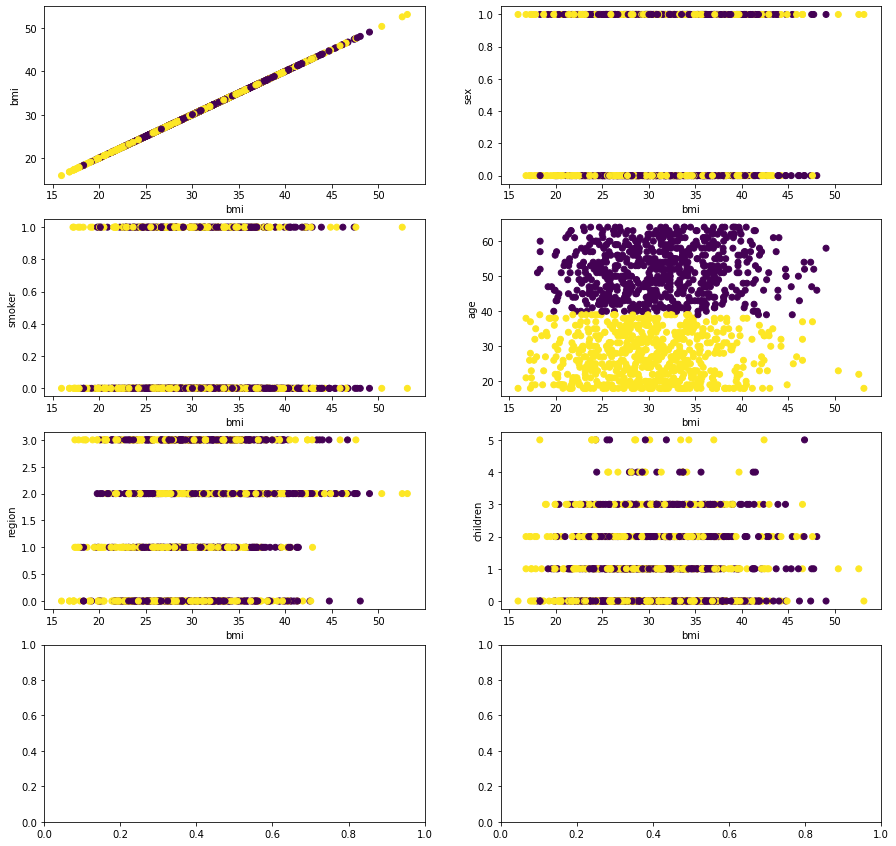

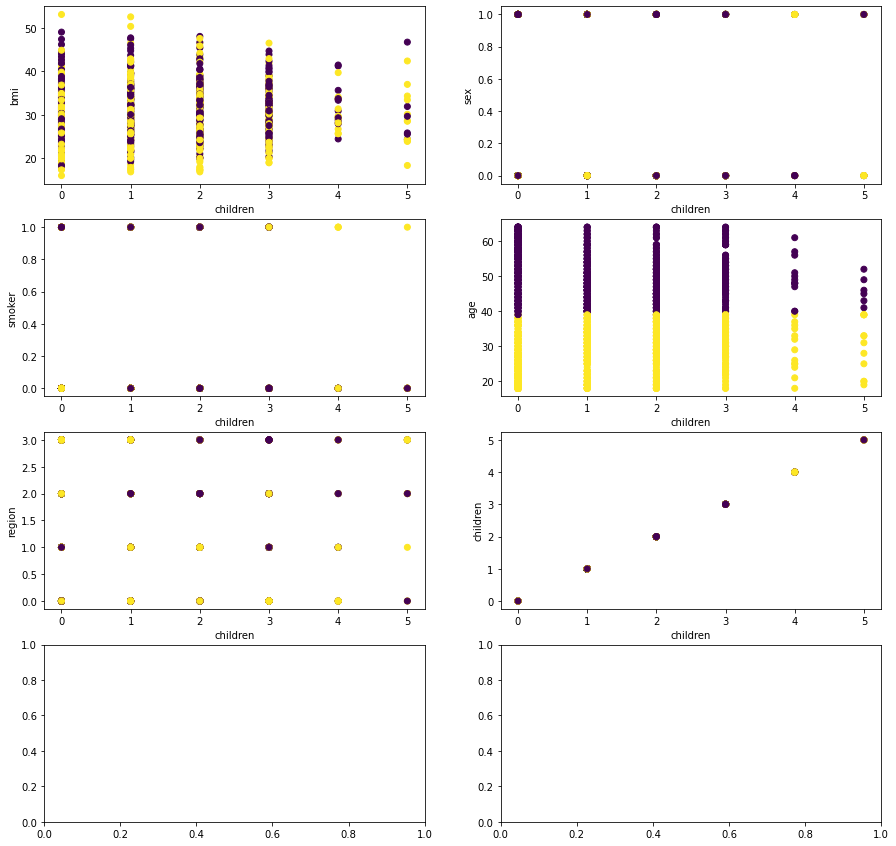

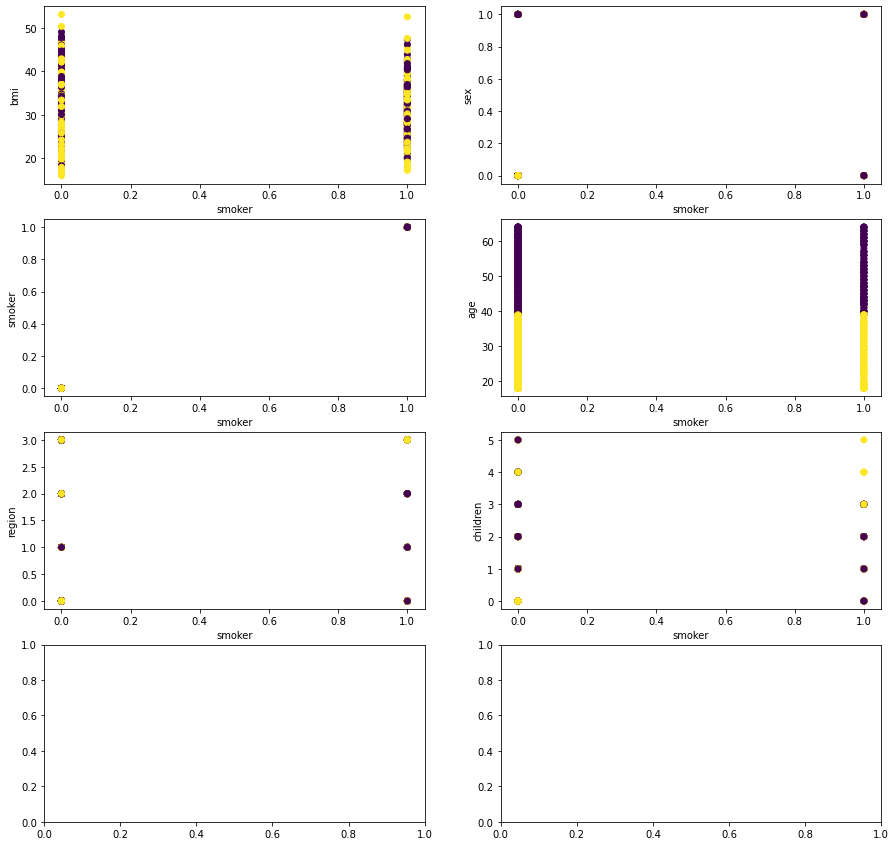

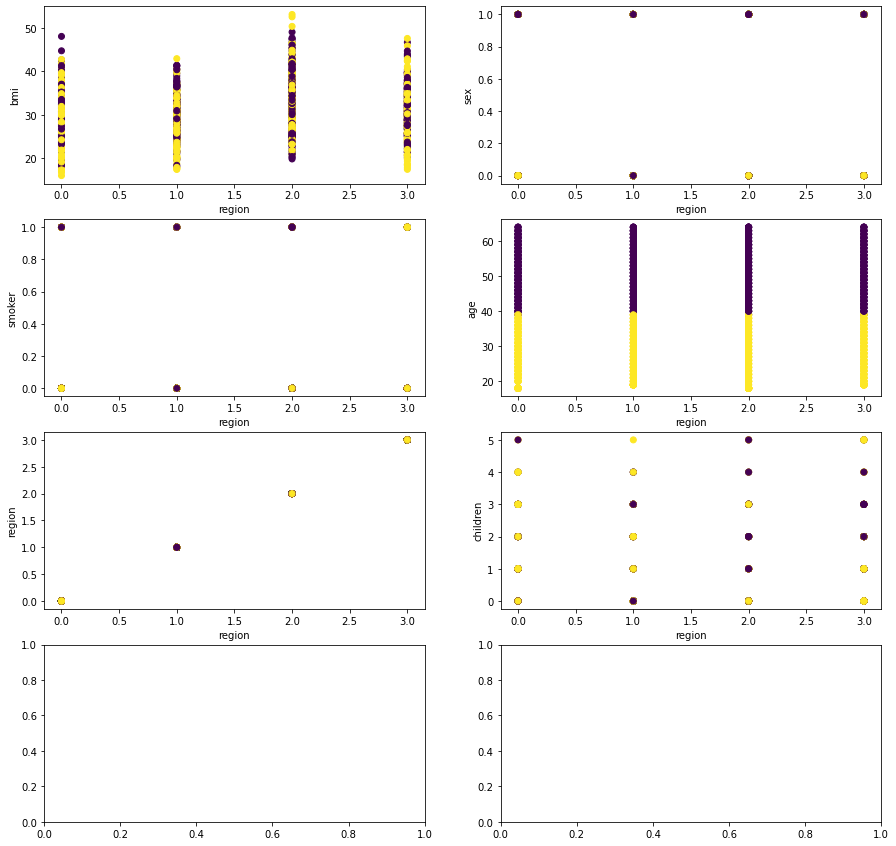

In [93]:
for col in x.columns:
    clustering(x, col, clusters)

## Analysis
Age is forming clusters with every features.

In [94]:
new_df = df.join(pd.DataFrame(clusters, columns=['clusters']), how= 'left')
new_df.head()

,age,sex,bmi,charges in INR,children,smoker,region,clusters
0,19,0,27.900,16884.92400,0,1,3,1
1,18,1,33.770,1725.55230,1,0,2,1
2,28,1,33.000,4449.46200,3,0,2,1
3,33,1,22.705,21984.47061,0,0,1,1
4,32,1,28.880,3866.85520,0,0,1,1


In [97]:
cluster_df = new_df.groupby('clusters')['age'].agg(['mean', 'median']) #performing grupby on clsters col and doing agg operations with Age col.

In [98]:
cluster_df.head()

,mean,median
clusters,,
0,51.473054,51
1,26.977612,27


In [99]:
cluster_df = new_df.merge(cluster_df, on= 'clusters', how= 'left')

In [100]:
cluster_df.head()

,age,sex,bmi,charges in INR,children,smoker,region,clusters,mean,median
0,19,0,27.900,16884.92400,0,1,3,1,26.977612,27
1,18,1,33.770,1725.55230,1,0,2,1,26.977612,27
2,28,1,33.000,4449.46200,3,0,2,1,26.977612,27
3,33,1,22.705,21984.47061,0,0,1,1,26.977612,27
4,32,1,28.880,3866.85520,0,0,1,1,26.977612,27


In [101]:
cluster_df.tail()

,age,sex,bmi,charges in INR,children,smoker,region,clusters,mean,median
1333,50,1,30.97,10600.5483,3,0,1,0,51.473054,51
1334,18,0,31.92,2205.9808,0,0,0,1,26.977612,27
1335,18,0,36.85,1629.8335,0,0,2,1,26.977612,27
1336,21,0,25.80,2007.9450,0,0,3,1,26.977612,27
1337,61,0,29.07,29141.3603,0,1,1,0,51.473054,51


For every cluster 0 and 1 the mean and median values is same. So, to consider curse of dimensionality its better to drop 2 column.

In [102]:
multiple_models(cluster_df, 'charges in INR') #checking accuracies for clster df

,model_name,rmse,r2_score
9,GradientBoostingRegressor,4384.976132,0.868862
5,RandomForestRegressor,4645.997864,0.852785
6,XGBRegressor,5100.948703,0.822542
8,AdaBoostRegressor,5332.020330,0.806100
0,Linear regression,5814.399615,0.769429
1,Lasso regression,5814.400568,0.769429
2,Ridge regression,5817.339415,0.769196
7,DecisionTreeRegressor,6432.609114,0.717793
4,KNeighborsRegressor,11383.575207,0.116205
3,SVR,12598.757491,-0.082554


In [111]:
x = cluster_df.drop(['charges in INR', 'clusters', 'mean'], axis=1)
y = cluster_df['charges in INR']

In [122]:
K_fold_CV(x,y) #checking performance with cluster df in k_fold_cv

,model_names,score_mean,score_std
8,GradientBoostingRegressor,0.856187,0.044943
6,RandomForestRegressor,0.834935,0.044594
7,AdaBoostRegressor,0.822743,0.041229
9,XGBRegressor,0.807429,0.057941
2,Ridge,0.744303,0.041582
1,Lasso,0.744298,0.041933
0,LinearRegression,0.744290,0.041952
4,DecisionTreeRegressor,0.696516,0.053818
5,KNeighborsRegressor,0.114393,0.065543
3,SVR,-0.105877,0.031129


In [123]:
cv_post_hpt(x, y) #checking performance with cluster df in cv

,model_names,score_mean,score_std
9,XGBRegressor,0.853628,0.045985
8,GradientBoostingRegressor,0.846840,0.048523
6,RandomForestRegressor,0.838292,0.046526
7,AdaBoostRegressor,0.819051,0.033497
1,Lasso,0.744557,0.041306
0,LinearRegression,0.744290,0.041952
2,Ridge,0.743516,0.039178
4,DecisionTreeRegressor,0.704457,0.043482
5,KNeighborsRegressor,0.146617,0.067293
3,SVR,-0.105877,0.031129


## Understanding feature importance using xgboost

In [104]:
xtrain, xtest, ytrain, ytest = train_and_test_split(cluster_df.drop('clusters', axis= 1), tcol='charges in INR')

In [105]:
xgb = XGBRegressor()

In [106]:
xgb.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

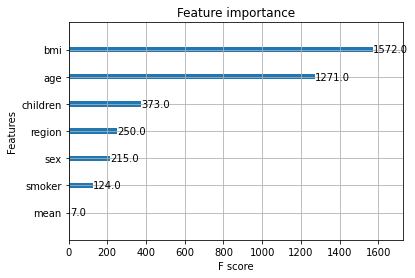

In [107]:
xgboost.plot_importance(xgb)

Now, checking accuracies using feature imp

In [138]:
new_df1 = cluster_df[['bmi', 'age', 'children', 'smoker', 'region', 'sex', 'charges in INR']]
new_df1.head()

,bmi,age,children,smoker,region,sex,charges in INR
0,27.900,19,0,1,3,0,16884.92400
1,33.770,18,1,0,2,1,1725.55230
2,33.000,28,3,0,2,1,4449.46200
3,22.705,33,0,0,1,1,21984.47061
4,28.880,32,0,0,1,1,3866.85520


In [139]:
cv_post_hpt(x= new_df1.drop('charges in INR', axis=1), y=new_df1['charges in INR'])

,model_names,score_mean,score_std
9,XGBRegressor,0.853197,0.046470
8,GradientBoostingRegressor,0.846137,0.048473
6,RandomForestRegressor,0.838748,0.046804
7,AdaBoostRegressor,0.812135,0.035774
1,Lasso,0.745019,0.041217
0,LinearRegression,0.744805,0.041861
2,Ridge,0.744043,0.039092
4,DecisionTreeRegressor,0.717332,0.064554
5,KNeighborsRegressor,0.148907,0.064936
3,SVR,-0.104918,0.030712


## RFE

In [140]:
cluster_df.head()

,age,sex,bmi,charges in INR,children,smoker,region,clusters,mean,median
0,19,0,27.900,16884.92400,0,1,3,1,26.977612,27
1,18,1,33.770,1725.55230,1,0,2,1,26.977612,27
2,28,1,33.000,4449.46200,3,0,2,1,26.977612,27
3,33,1,22.705,21984.47061,0,0,1,1,26.977612,27
4,32,1,28.880,3866.85520,0,0,1,1,26.977612,27


In [141]:
rfe = RFE(GradientBoostingRegressor())

In [142]:
rfe.fit(cluster_df.drop(['charges in INR', 'clusters'], axis=1), y=cluster_df['charges in INR'])

RFE(estimator=GradientBoostingRegressor())

In [143]:
rfe.support_

array([ True, False,  True,  True,  True, False, False, False])

In [144]:
cluster_df.columns

Index(['age', 'sex', 'bmi', 'charges in INR', 'children', 'smoker', 'region',
       'clusters', 'mean', 'median'],
      dtype='object')

In [145]:
new_df2 = cluster_df[['age', 'bmi', 'children', 'charges in INR']] #Imp features by rfe
new_df2.head()

,age,bmi,children,charges in INR
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


In [146]:
cv_post_hpt(x=new_df2.drop('charges in INR', axis=1), y=cluster_df['charges in INR'])

,model_names,score_mean,score_std
2,Ridge,0.111315,0.040879
0,LinearRegression,0.111310,0.040876
1,Lasso,0.111310,0.040887
5,KNeighborsRegressor,0.033541,0.058228
9,XGBRegressor,0.007125,0.071419
6,RandomForestRegressor,-0.035924,0.080292
8,GradientBoostingRegressor,-0.075308,0.094832
7,AdaBoostRegressor,-0.098717,0.130989
3,SVR,-0.104771,0.030901
4,DecisionTreeRegressor,NaN,NaN


Here, rfe doesn't perform well

## Building learning curve analysis

In [147]:
def generate_learning_curve(estimator, x, y, model_name):
    train_size, train_score, test_score = learning_curve(estimator= estimator, X=x, y=y, cv=10)
    train_score_mean = np.mean(train_score, axis=1)
    test_score_mean = np.mean(test_score, axis=1)
    plt.plot(train_size, train_score_mean, c= 'b')
    plt.plot(train_size, test_score_mean, c= 'r')
    plt.xlabel('Samples')
    plt.ylabel('Accuracies')
    plt.title('Learning Curve for '+ model_name)
    plt.legend(('training_accuracy','testing_accuracy'))

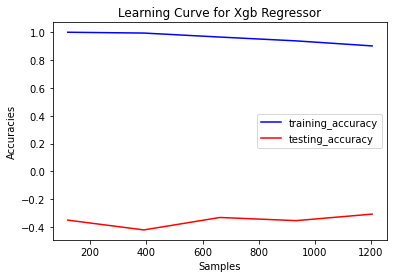

In [150]:
#for 1 model only
generate_learning_curve(XGBRegressor(), x=new_df2.drop('charges in INR', axis=1), y= new_df2['charges in INR'], model_name= 'Xgb Regressor')

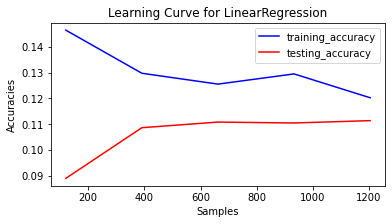

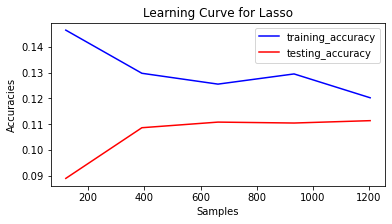

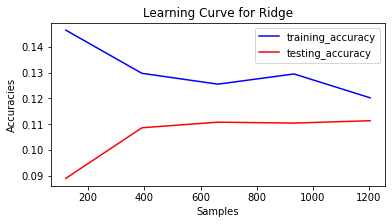

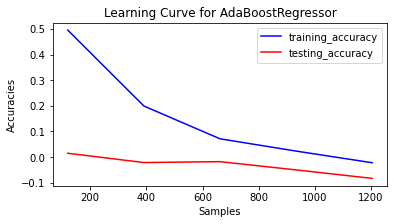

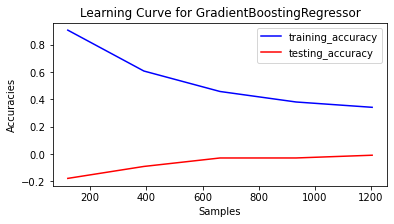

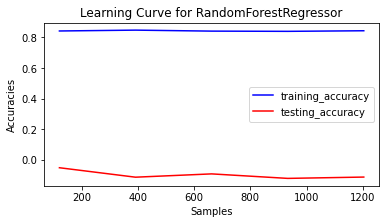

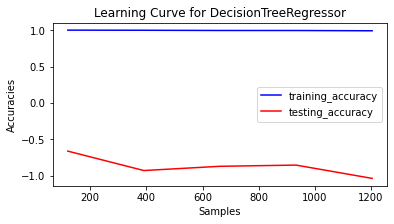

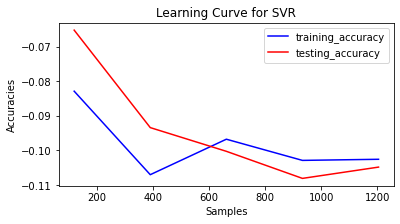

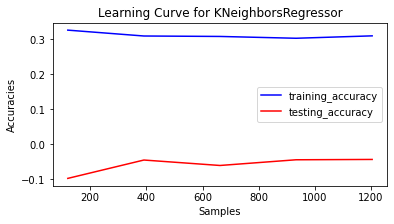

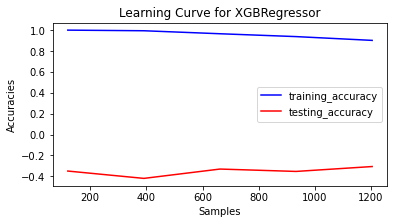

In [151]:
#for each model
model_names = [LinearRegression(), Lasso(), Ridge(), AdaBoostRegressor(), GradientBoostingRegressor(), 
               RandomForestRegressor(), DecisionTreeRegressor() ,SVR(), KNeighborsRegressor(),
               XGBRegressor()]

for a, model in enumerate(model_names):
    fg = plt.figure(figsize = (6,3))
    ax = fig.add_subplot(5,2,a+1)
    generate_learning_curve(model_name = type(model_names[a]).__name__ , estimator = model, x=new_df2.drop('charges in INR', axis=1), y= new_df2['charges in INR'])